Data shape after preprocessing: (494021, 40)
Training Naive Bayes...
Naive Bayes - Training Accuracy: 0.9079, Testing Accuracy: 0.9078
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       435
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       0.03      0.88      0.06         8
           4       0.01      0.67      0.01         3
           5       0.09      0.92      0.17       265
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         2
           8       0.01      1.00      0.02         1
           9       1.00      0.99      1.00     21294
          10       0.00      0.00      0.00        45
          11       0.99      0.57      0.72     19353
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14  

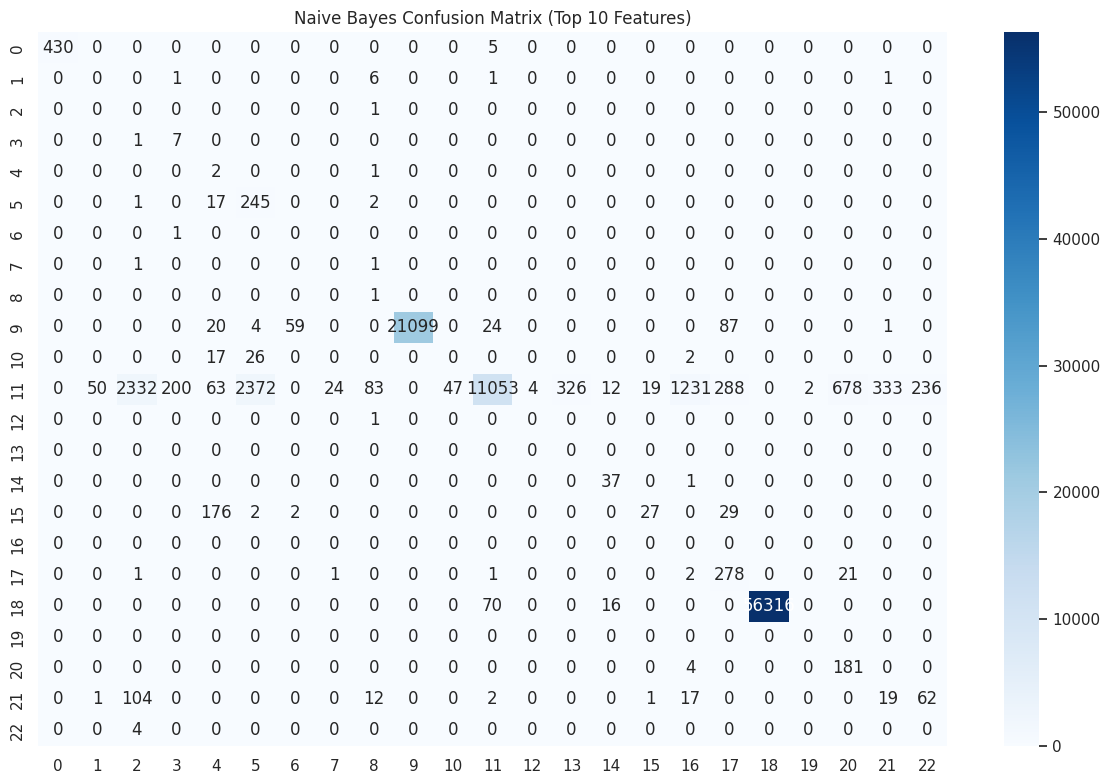

------------------------------------------------------------
Training Decision Tree...
Decision Tree - Training Accuracy: 1.0000, Testing Accuracy: 0.9989
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       435
           1       0.75      0.67      0.71         9
           2       0.00      0.00      0.00         1
           3       0.88      0.88      0.88         8
           4       0.50      0.67      0.57         3
           5       0.91      0.95      0.93       265
           6       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21294
          10       0.68      0.58      0.63        45
          11       1.00      1.00      1.00     19353
          12       1.00      1.00      1.00         1
          14       1.00      1.00      1.00   

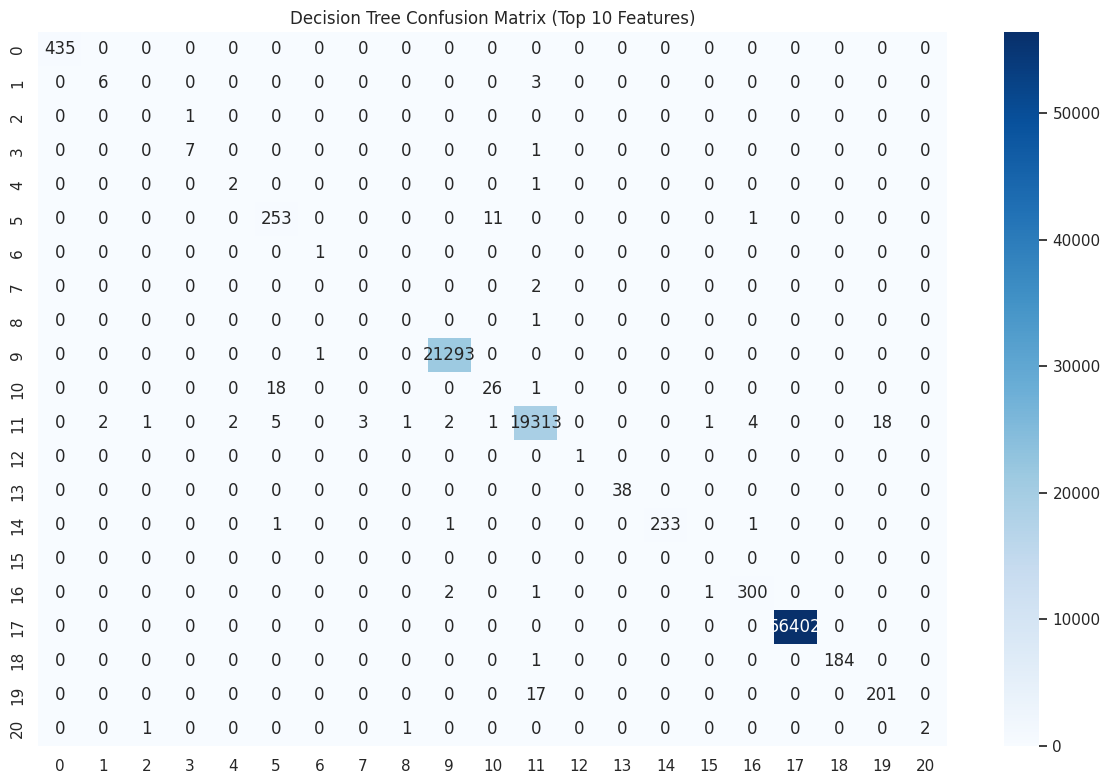

------------------------------------------------------------
Training Random Forest...
Random Forest - Training Accuracy: 1.0000, Testing Accuracy: 0.9990
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       435
           1       1.00      0.44      0.62         9
           2       0.33      1.00      0.50         1
           3       1.00      0.88      0.93         8
           4       0.67      0.67      0.67         3
           5       0.93      0.97      0.95       265
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21294
          10       0.76      0.58      0.66        45
          11       1.00      1.00      1.00     19353
          12       0.00      0.00      0.00         1
          14       0.97      1.00      0.99   

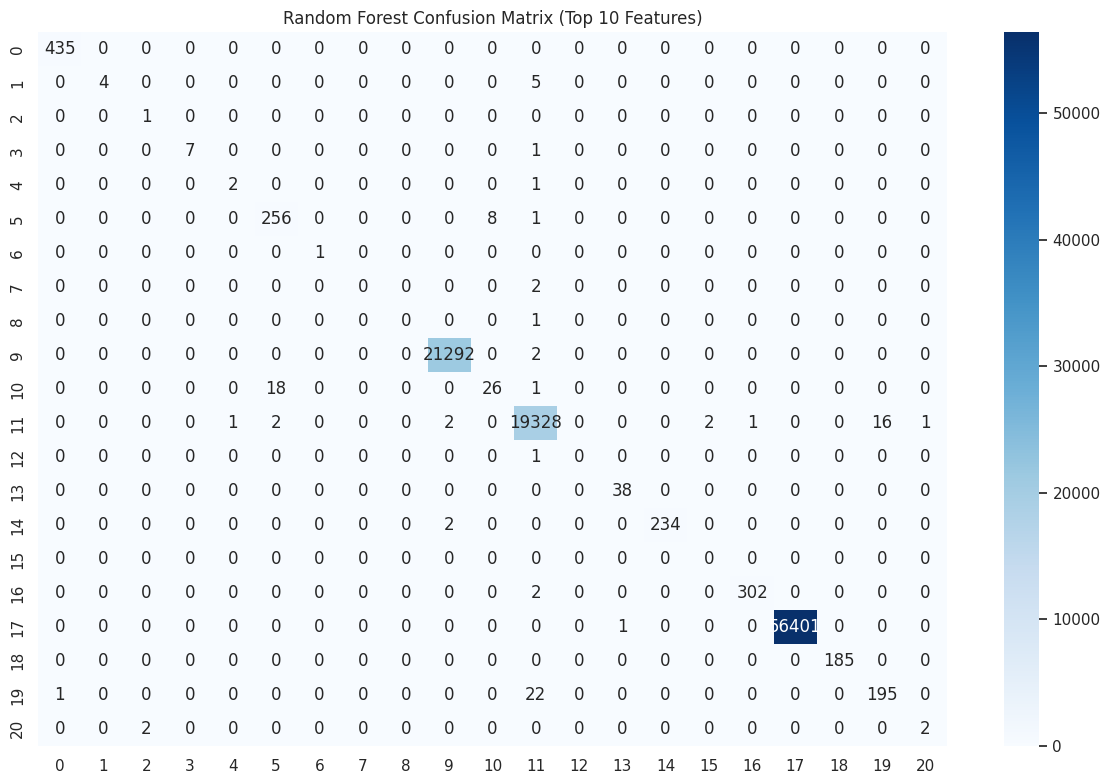

------------------------------------------------------------
Training SVM...
SVM - Training Accuracy: 0.9917, Testing Accuracy: 0.9917
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.82      0.03      0.06       435
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         1
           3       1.00      0.75      0.86         8
           4       0.00      0.00      0.00         3
           5       0.76      0.66      0.71       265
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21294
          10       1.00      0.38      0.55        45
          11       0.96      1.00      0.98     19353
          12       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        38
          15       0.9

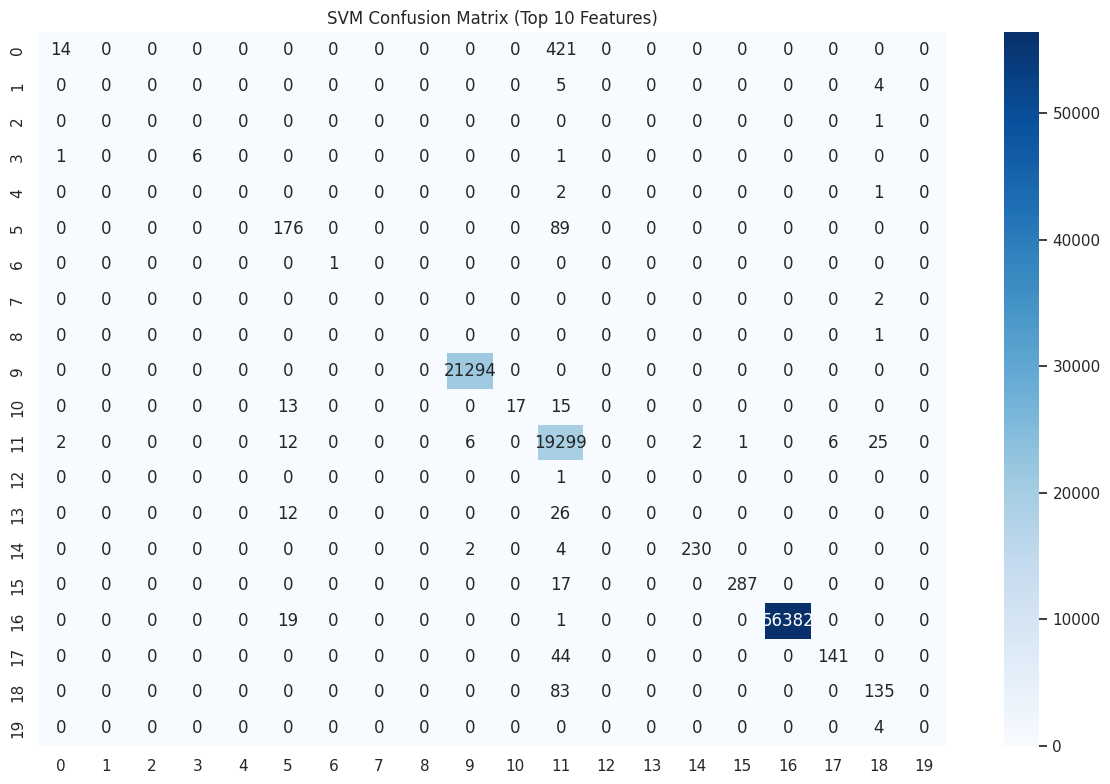

------------------------------------------------------------


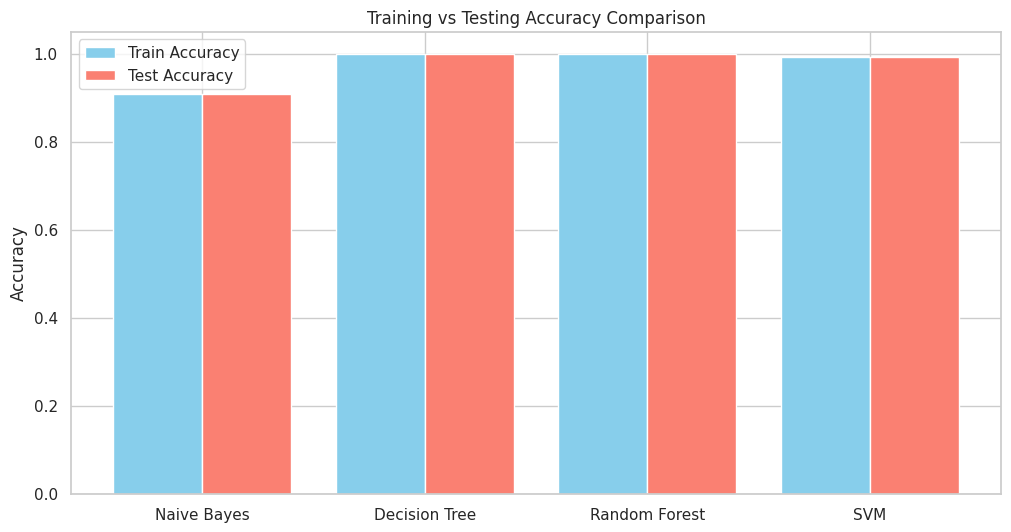

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set a visual theme
sns.set_theme(style="whitegrid")

def load_and_preprocess_data(file_path):
    """Load data, handle missing values, and remove uniform columns."""
    data = pd.read_csv(file_path, header=None)
    data.replace('?', np.nan, inplace=True)
    data.dropna(inplace=True)

    # Remove columns with uniform values
    uniform_columns = [col for col in data.columns if len(data[col].unique()) == 1]
    data.drop(columns=uniform_columns, inplace=True)

    return data

def encode_and_scale_data(data):
    """Encode categorical features and scale the data."""
    protocol_type_mapping = {'tcp': 0, 'udp': 1, 'icmp': 2}
    flag_mapping = {'SF': 0, 'S0': 1, 'REJ': 2, 'RSTR': 3, 'RSTO': 4, 'SH': 5, 'S1': 6, 'S2': 7, 'S3': 8, 'OTH': 9}

    # Apply mappings
    data[1] = data[1].map(protocol_type_mapping)
    data[3] = data[3].map(flag_mapping)

    # Drop irrelevant feature 'service'
    data.drop(columns=[2], inplace=True)

    # Encode remaining categorical features
    label_encoder = LabelEncoder()
    for column in data.columns:
        if data[column].dtype == object:
            data[column] = label_encoder.fit_transform(data[column])

    # Split data into features (X) and target (y)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].astype(int)  # Ensure target variable is of integer type

    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y

def select_important_features(X_train, y_train, num_features=10):
    """Select the top 'num_features' important features using a RandomForestClassifier."""
    # Impute missing values using the mean
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)

    # Fit the RandomForest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_imputed, y_train)

    # Get feature importances and select the top 'num_features'
    importances = model.feature_importances_
    indices = np.argsort(importances)[-num_features:]  # Indices of the top features

    return indices

def train_and_evaluate_model(X_train, X_test, y_train, y_test, models, feature_indices=None):
    """Train models and evaluate them, using only the specified feature indices if provided."""
    model_results = {}
    train_accuracies = {}
    test_accuracies = {}
    imputer = SimpleImputer(strategy='mean')

    if feature_indices is not None:
        # Select only the important features
        X_train = X_train[:, feature_indices]
        X_test = X_test[:, feature_indices]

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Fit the model on the imputed training data
        model.fit(X_train_imputed, y_train)

        # Make predictions on the train and test sets
        y_pred_train = model.predict(X_train_imputed)
        y_pred_test = model.predict(X_test_imputed)

        # Evaluate the model performance
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)

        train_accuracies[model_name] = train_accuracy
        test_accuracies[model_name] = test_accuracy

        print(f"{model_name} - Training Accuracy: {train_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")
        print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred_test, zero_division=0))

        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues')

        # Adjust title based on whether feature_indices is used
        if feature_indices is not None:
            plt.title(f'{model_name} Confusion Matrix (Top {len(feature_indices)} Features)')
        else:
            plt.title(f'{model_name} Confusion Matrix')

        plt.tight_layout()
        plt.show()

        print('-' * 60)

    return train_accuracies, test_accuracies


def plot_model_accuracies(train_accuracies, test_accuracies):
    """Plot the accuracies of different models for comparison."""
    plt.figure(figsize=(12, 6))
    x = range(len(train_accuracies))

    # Plot training and testing accuracies side by side
    plt.bar([i - 0.2 for i in x], train_accuracies.values(), width=0.4, label='Train Accuracy', align='center', color='skyblue')
    plt.bar([i + 0.2 for i in x], test_accuracies.values(), width=0.4, label='Test Accuracy', align='center', color='salmon')

    plt.xticks(x, train_accuracies.keys())
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy Comparison')
    plt.legend()
    plt.show()

# Main execution

# Load and preprocess the data
data = load_and_preprocess_data('/content/kddcup.data_10_percent')
print("Data shape after preprocessing:", data.shape)

# Encode categorical features and scale data
X_scaled, y = encode_and_scale_data(data)

# Train-test split (before selecting top features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Select the top 10 important features based on training data
top_features = select_important_features(X_train, y_train, num_features=10)

# Define models to be trained
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Train models and evaluate them using only the top 10 important features
train_accuracies, test_accuracies = train_and_evaluate_model(X_train, X_test, y_train, y_test, models, feature_indices=top_features)

# Plot the accuracies of the different models
plot_model_accuracies(train_accuracies, test_accuracies)
